In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Memory, Parallel, delayed
# Incantation to get latest version
import test_Noll
import importlib
importlib.reload(test_Noll)
from test_Noll import *

# Some wierdness in Table IV of Noll 1976
Comparing values in the table with those computed using the formulae given in the paper shows errors several times the least significant decimal place printed in the table for the first few rows. Given that each line of the table is computed from the previous line, you would expect the errors to accumulate as you go down the table, but in general the reverse happens, and the error reduces as we go down the table.

In [2]:
def check_table_iv(const=0.023):
    resid=noll_piston_residual_analytic(const=const)
    for i in range(len(noll_table_iv)):
        print("{:8.5f} {:8.5f} {:8.2e}".format(noll_table_iv[i],resid,resid-noll_table_iv[i]))
        i=i+1
        n,m=jtonm(i+1)
        resid-=noll_covariance_analytic(n,n,const=const)
check_table_iv()

 1.02990  1.03713 7.23e-03
 0.58200  0.58620 4.20e-03
 0.13400  0.13528 1.28e-03
 0.11100  0.11195 9.54e-04
 0.08800  0.08863 6.30e-04
 0.06480  0.06531 5.07e-04
 0.05870  0.05909 3.87e-04
 0.05250  0.05287 3.67e-04
 0.04630  0.04665 3.48e-04
 0.04010  0.04043 3.28e-04
 0.03770  0.03796 2.63e-04
 0.03520  0.03550 2.98e-04
 0.03280  0.03303 2.33e-04
 0.03040  0.03057 1.67e-04
 0.02790  0.02810 2.02e-04
 0.02670  0.02691 2.06e-04
 0.02550  0.02571 2.11e-04
 0.02430  0.02451 2.15e-04
 0.02320  0.02332 1.19e-04
 0.02200  0.02212 1.23e-04
 0.02080  0.02093 1.27e-04


We can reduce the error to acceptable values by setting the constant in front of the power spectrum to 0.02284 instead of the value 0.023 given in Noll's paper. 

In [3]:
check_table_iv(0.02284) 

 1.02990  1.02992 1.51e-05
 0.58200  0.58213 1.26e-04
 0.13400  0.13434 3.37e-04
 0.11100  0.11118 1.75e-04
 0.08800  0.08801 1.37e-05
 0.06480  0.06485 5.22e-05
 0.05870  0.05868 -2.42e-05
 0.05250  0.05250 -5.81e-07
 0.04630  0.04632 2.30e-05
 0.04010  0.04015 4.66e-05
 0.03770  0.03770 -1.35e-06
 0.03520  0.03525 5.07e-05
 0.03280  0.03280 2.72e-06
 0.03040  0.03035 -4.52e-05
 0.02790  0.02791 6.79e-06
 0.02670  0.02672 1.93e-05
 0.02550  0.02553 3.17e-05
 0.02430  0.02434 4.42e-05
 0.02320  0.02316 -4.33e-05
 0.02200  0.02197 -3.08e-05
 0.02080  0.02078 -1.83e-05


Using a higher-precision value of this constant (whether using Fried's constant of 6.88 as the only low-precision number, or computing it to high precision by evaluating Fried's formula) yields an increased discrepancy. 

In [9]:
fried=2*((24/5)*gamma(6/5))**(5/6)
print("fried=",fried)
const=fried*gamma(11/6)*(5/6)/(2*np.pi**(8/3)*gamma(1/6))
print("const =",const)
check_table_iv(const)

fried= 6.883877182293812
const = 0.022895587108555188
 1.02990  1.03242 2.52e-03
 0.58200  0.58354 1.54e-03
 0.13400  0.13466 6.64e-04
 0.11100  0.11145 4.46e-04
 0.08800  0.08823 2.28e-04
 0.06480  0.06501 2.10e-04
 0.05870  0.05882 1.19e-04
 0.05250  0.05263 1.27e-04
 0.04630  0.04644 1.36e-04
 0.04010  0.04024 1.44e-04
 0.03770  0.03779 9.04e-05
 0.03520  0.03534 1.36e-04
 0.03280  0.03288 8.26e-05
 0.03040  0.03043 2.86e-05
 0.02790  0.02797 7.47e-05
 0.02670  0.02678 8.43e-05
 0.02550  0.02559 9.39e-05
 0.02430  0.02440 1.03e-04
 0.02320  0.02321 1.31e-05
 0.02200  0.02202 2.26e-05
 0.02080  0.02083 3.22e-05


So did why did Noll use a value for this constant which is neither the value quoted in the his own paper nor a more precise value?

# Test the simulator against Winker 1991

In [5]:
# Use the joblib Memory decorator to avoid having to recompute long-running calculations
memory = Memory("cache", verbose=0)
@memory.cache
def MemoWinker(
    diameter=32,
    L0Min=16,
    L0Max=8000,
    numL0=20,
    numIter=100,
    maxRadial=2,
    nfftOuter=256,
    nfftInner=256,
    randomSeed=12345,
):
    """Memoised wrapper for the Winker function"""
    np.random.seed(randomSeed)
    return Winker(
        diameter, L0Min, L0Max, numL0, numIter, maxRadial, nfftOuter, nfftInner
    )


t = MemoWinker(numIter=1000, diameter=100, randomSeed=5432112)

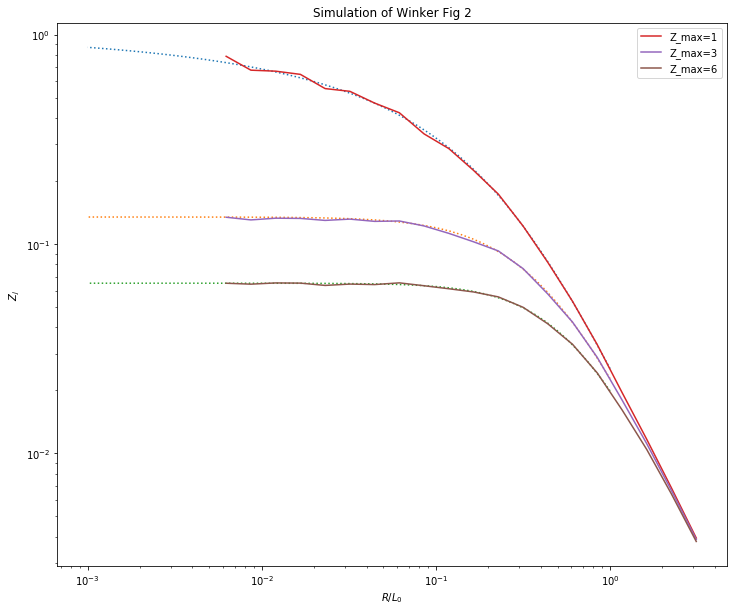

In [6]:
def PlotWinker(t, diameter):
    """Reproduce Fig 2 from Winker 1991"""
    # Plot theoretical values
    L0=np.logspace(0,3,50)
    resid=winker_residual(L0,2)
    for n in range(len(resid)):
        plt.loglog(1/(L0),resid[n],ls="dotted")
    # Plot simulation values
    L0 = 2 * t["L0"] / diameter
    for z in [0, 2, 5]:
        plt.loglog(1 / L0, t["Z" + str(z)], label="Z_max=" + str(z+1))
    plt.legend()

def winker_residual(L0,max_n):
    resid=np.empty((max_n+1,len(L0)))
    for i in range(len(L0)):
        L=L0[i]
        resid[0,i]=winker_piston_residual(L0=L)
        for n in range(1,max_n+1):
            resid[n,i]=resid[n-1,i]-winker_variance_quad(n,R=1,r0=2,L0=L)*(n+1)
    return resid

plt.figure(figsize=(12,10))
plt.xlabel(r"$R/L_0$")
plt.ylabel("$Z_j$")
plt.title("Simulation of Winker Fig 2")
PlotWinker(t, 100)